In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [3, 3]
sns.set() # apply the seaborn defaults to plotted figures (e.g. theme, scaling, color palette), instead of matplotlib's

In [3]:
RANDOM_SEED = 886
np.random.seed(RANDOM_SEED) # use for reproducibility

In [4]:
!ls ../mini_cinic10/

classes_and_names.csv
images
README.txt
test.npz
train.npz
val.npz


In [5]:
PATH_TO_DATA = os.path.join("..", "mini_cinic10")

train_data = np.load(os.path.join(PATH_TO_DATA, "train.npz"))
val_data   = np.load(os.path.join(PATH_TO_DATA, "val.npz"))
# test_data  = np.load(os.path.join(PATH_TO_DATA, "test.npz")) # assume this doesn't exist

In [6]:
X, y = train_data['xs'], train_data['ys']
X_val, y_val = val_data['xs'], val_data['ys']

In [7]:
print("Train: ")
print("X:", X.shape, X.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print("y:", y.shape, y.dtype)

print("\nValidation: ")
print("X_val:", X_val.shape, X_val.dtype) # 3072 = 3 * 1024 = 3 * (32 * 32)
print("y_val:", y_val.shape, y_val.dtype)

Train: 
X: (80000, 3072) uint8
y: (80000,) uint8

Validation: 
X_val: (10000, 3072) uint8
y_val: (10000,) uint8


In [8]:
IMG_WIDTH = IMG_HEIGHT = 32
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3) # RGB images
IMG_FLAT_SHAPE = (IMG_HEIGHT*IMG_WIDTH*3, )

# classes_and_names.csv
CLASS_NAMES = {
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}
CLASS_COUNT = len(CLASS_NAMES)

In [9]:
def unflatten(flat_img):
    ''' Reverts a flattened image back into a 3-layer RGB matrix representation '''
    return flat_img.reshape(IMG_SHAPE)

In [10]:
def show_image(img_index, X, y, figsize=None):
    ''' Shows the image represented by img_index-th row of X '''
    if figsize != None:
        fig = plt.figure(figsize=figsize)
    plt.imshow(unflatten(X[img_index]))
    plt.title(f'idx #{img_index} ({CLASS_NAMES[y[img_index]]})')
    plt.axis(False)
    plt.show()

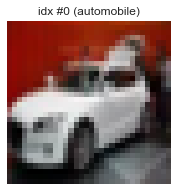

In [11]:
show_image(0, X, y)

In [12]:
y.shape

(80000,)

In [13]:
def onehot_encode(y):
    n_examples, *_ = y.shape
    onehot = np.zeros(shape=(n_examples, CLASS_COUNT))
    onehot[np.arange(n_examples), y] = 1
    return onehot

In [14]:
onehot_y = onehot_encode(y) # makes y a onehot encoded vector
onehot_y_val = onehot_encode(y_val)

In [15]:
print("Train: ")
print("onehot_y:", onehot_y.shape, onehot_y.dtype)

print("\nValidation: ")
print("onehot_y_val:", onehot_y_val.shape, onehot_y_val.dtype)

Train: 
onehot_y: (80000, 10) float64

Validation: 
onehot_y_val: (10000, 10) float64


In [16]:
def z_score_normalized(X, eps=1e-12):
    mu = np.mean(X)
    sigma = np.std(X)
    return (X - mu) / (sigma if sigma != 0 else eps)

In [17]:
normalized_X = z_score_normalized(X)
normalized_X_val = z_score_normalized(X_val)

print("mean:", np.mean(normalized_X), "std:", np.std(normalized_X))
print("mean:", np.mean(normalized_X_val), "std:", np.std(normalized_X_val))

mean: 3.145816940275381e-17 std: 0.9999999999999993
mean: 5.884922179196413e-17 std: 0.9999999999999993


In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [19]:
def softmax(z, eps=1e-12):
    exp_z_sum = np.sum(np.exp(z))
    return np.exp(z) / (exp_z_sum if exp_z_sum != 0 else eps)

In [20]:
def h_theta(theta, b, X, y):
    z = X.dot(theta) + b
    return softmax(z)

In [21]:
def log(z, eps=1e-32):
    return np.log(np.maximum(z, eps))

def categorical_cross_entropy(theta, b, X, y):
    y_pred = h_theta(theta, b, X, y)
    return -np.sum(y*log(y_pred))

In [22]:
def loss_function(theta, b, X, y):
    return categorical_cross_entropy(theta, b, X, y)

In [23]:
def shuffled_X_y(X, y, seed):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    p = np.random.permutation(m)
    return X[p], y[p]

In [24]:
def eval_gradient(theta, b, X, y):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    assert(X.shape[1] == theta.shape[0]), f"X.shape[1] != theta.shape[0] for shapes: {X.shape} of X, and {theta.shape} of theta"
    
    m = X.shape[0]
    y_pred = h_theta(theta, b, X, y)
    
    return (1 / m) * X.T.dot(y_pred - y), (1 / m) * (y_pred - y).T.dot(np.ones(m)) # FIXME

In [25]:
def get_batches(X, y, batch_size):
    assert(X.shape[0] == y.shape[0]), f"X.shape[0] != y.shape[0] for shapes: {X.shape} of X, and {y.shape} of y"
    m = y.shape[0]
    n_of_batches = m // batch_size
    try:
        return zip(np.split(X, n_of_batches), np.split(y, n_of_batches))
    except:
        warnings.warn(f"batch_size={batch_size} does not result in an equal division for shapes: " +
                      f"{X.shape} of X, and {y.shape} of y. The last batch will have size {m % batch_size}")
        return zip(np.array_split(X, n_of_batches), np.array_split(y, n_of_batches))

In [26]:
def batch_GD_step(theta, b, X, y, learning_rate, batch_size=None):
    if not batch_size:
        # vanilla
        theta_grad, b_grad = eval_gradient(theta, b, X, y)
        theta -= learning_rate * theta_grad
        b -= b * b_grad
    else:
        # mini batch
        X, y = shuffled_X_y(X, y, seed=RANDOM_SEED)
        for batch_X, batch_y in get_batches(X, y, batch_size):
            theta_grad, b_grad = eval_gradient(theta, b, batch_X, batch_y)
            theta -= learning_rate * theta_grad
            b -= b * b_grad
    return theta, b

## Gradient Descent Loop

In [27]:
def get_randomly_initialized_theta(n_features, rand_seed=RANDOM_SEED):
    rand = np.random.RandomState(seed=rand_seed)
    sigma = np.sqrt(2 / (n_features + 1))
    return sigma * rand.randn(n_features, CLASS_COUNT)

def get_zero_initialized_theta(n_features):
    return np.zeros(shape=(n_features, CLASS_COUNT))

In [28]:
rand_theta = get_randomly_initialized_theta(n_features=IMG_FLAT_SHAPE[0])
bias = np.zeros(CLASS_COUNT)

print(rand_theta.shape, bias.shape)

(3072, 10) (10,)


In [29]:
import time

start = time.time()
batch_GD_step(rand_theta, bias, normalized_X, onehot_y, learning_rate=0.001, batch_size=64)
vec_elapsed = time.time() - start

print(f'elapsed time for vectorized gradient descent step: {vec_elapsed:.4f}s')

elapsed time for vectorized gradient descent step: 1.9344s


In [30]:
def __gradient_descent(theta, b, X, y, X_val, y_val, learning_rate, n_epochs, batch_size=None):
    
    loss = loss_function(theta, b, X, y)
    val_loss = loss_function(theta, b, X_val, y_val)
    
    # stores the best values for minimizing J(theta) on the validation set
    best_params = theta.copy(), b.copy()
    best_val_loss = val_loss
    
    # save the loss values for plotting
    history = { 
        "best_val_loss": best_val_loss, 
        "best_val_loss_epoch": 0, 
        "loss": [loss], # training set
        "val_loss": [val_loss] # validation set
    }
    
    for epoch in range(n_epochs):
        theta, b = batch_GD_step(theta, b, X, y, learning_rate, batch_size)
    
        loss = loss_function(theta, b, X, y)
        history["loss"].append(loss) # training set
        
        val_loss = loss_function(theta, b, X_val, y_val)
        history["val_loss"].append(val_loss) # validation set
        
        # update the best loss and store the current parameters if val_loss < best_val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = theta.copy(), b.copy()
            history["best_val_loss_epoch"] = epoch + 1
        
        print(f"({epoch + 1} / {n_epochs}) training: {loss:.4f} | validation: {val_loss:.4f}", end='\r')
        
    history["best_val_loss"] = best_val_loss
    return best_params, history

## Trainning

In [31]:
import warnings

In [35]:
def train(theta, b, X, y, X_val, y_val, learning_rate, n_epochs, batch_size=None):
    if batch_size == None:
        warnings.warn("Did you forget to specify batch_size? You're running a vannila gradient descent")
    
    best_params, history = __gradient_descent(theta, b, X, y, X_val, y_val, learning_rate, n_epochs, batch_size)
    
    history["batch_size"]    = batch_size
    history["learning_rate"] = learning_rate
    history["n_epochs"]      = n_epochs
    
    return best_params, history # (theta, b), history

In [33]:
from matplotlib import style
from matplotlib import colors as mpl_colors

def get_colors():
    colors = [
        '#348ABD',
        '#E24A33',
        '#A60628',
        '#467821',
        '#CF4457',
        '#7A68A6',
        '#188487',
    ]
    init_colors = set(colors)
    other_colors = sorted(mpl_colors.cnames.keys())
    colors.extend(c for c in other_colors if c not in init_colors)
    return colors

def plot_train_history(hist):
    keys = sorted(hist.keys())
    for k, c in zip(keys, get_colors()):
        plt.plot(hist[k], color=c)
    plt.legend(keys, loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel('metric')
    plt.title('train metrics')
    plt.show()

In [36]:
theta, history = train(
    rand_theta, bias,
    normalized_X, onehot_y, normalized_X_val, onehot_y_val,
    learning_rate=0.0001,
    n_epochs=20, batch_size=64
)

d:\documents\github\unicamp\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
d:\documents\github\unicamp\lib\site-packages\numpy\core\fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
d:\documents\github\unicamp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
d:\documents\github\unicamp\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


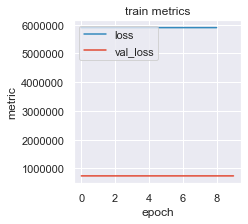

In [41]:
plot_train_history({ 'loss': history['loss'], 'val_loss': history['val_loss'] })